# Muse脳波データ分析ノートブック（基本分析）

このノートブックでは、Museヘッドバンドで取得した脳波データの基本的な分析を行います。

## 目次
1. データの読み込みと前処理
2. 基本統計量の確認
3. バンドパワー分析
4. 周波数解析（FFT・スペクトログラム）
5. 条件比較とスコア化

## 関連ノートブック

詳細な分析については、以下の専門ノートブックを参照してください：

- **[laterality_analysis.ipynb](laterality_analysis.ipynb)**: 左右半球の非対称性分析
- **[fm_theta_analysis.ipynb](fm_theta_analysis.ipynb)**: サマタ瞑想のfmシータ波分析

## 1. データの読み込みと前処理

まず必要なライブラリをインポートし、CSVデータを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mne
from IPython.display import display

%matplotlib inline

# 日本語フォント設定
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# データファイルのパス
DATA_PATH = Path('../data/samples/mindMonitor_2025-10-17--15-57-54_1095381020592657976.csv')
print(f'Loading: {DATA_PATH}')

# CSVを読み込み
df = pd.read_csv(DATA_PATH)

# タイムスタンプを日時型に変換
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df = df.dropna(subset=['TimeStamp']).sort_values('TimeStamp').reset_index(drop=True)

# データの先頭を確認
display(df.head())
print(f'\nデータ形状: {df.shape[0]} 行 × {df.shape[1]} 列')
print(f'記録時間: {df["TimeStamp"].min()} ~ {df["TimeStamp"].max()}')
print(f'計測時間: {(df["TimeStamp"].max() - df["TimeStamp"].min()).total_seconds():.1f} 秒')

Loading: ../data/samples/mindMonitor_2025-10-26--08-32-20_1403458594426768660.csv


/tmp/ipykernel_25686/2195548156.py:6: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Optics15,Optics16,Heart_Rate,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2025-10-26 08:32:21.081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected MuseS-FA35
1,2025-10-26 08:32:21.091,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
2,2025-10-26 08:32:21.095,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
3,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN
4,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN



データ形状: 377893 行 × 59 列
記録時間: 2025-10-26 08:32:21.081000 ~ 2025-10-26 08:57:31.748000
計測時間: 1510.7 秒


## 2. 基本統計量の確認

各周波数バンドの基本統計を確認します。

- **Delta (0.5-4 Hz)**: 深い睡眠
- **Theta (4-8 Hz)**: 瞑想、創造性
- **Alpha (8-13 Hz)**: リラックス、目を閉じた状態
- **Beta (13-30 Hz)**: 集中、活動
- **Gamma (30-50 Hz)**: 高度な認知処理

In [3]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
summary_rows = []

for band in bands:
    cols = [c for c in df.columns if c.startswith(f'{band}_')]
    if not cols:
        continue
    
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    numeric = numeric.replace(0.0, np.nan)  # ゼロは欠損として扱う
    
    summary_rows.append({
        'バンド': band,
        '平均値': numeric.stack().mean(),
        '標準偏差': numeric.stack().std(),
        '有効データ率 (%)': numeric.notna().stack().mean() * 100,
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df.style.format({
    '平均値': '{:.4f}',
    '標準偏差': '{:.4f}',
    '有効データ率 (%)': '{:.2f}'
}))

,バンド,平均値,標準偏差,有効データ率 (%)
0,Delta,0.1100,0.4865,99.07
1,Theta,-0.0241,0.4339,99.07
2,Alpha,0.4503,0.5383,99.07
3,Beta,-0.0257,0.3022,99.07
4,Gamma,-0.1752,0.3808,99.07


## 4. バンドパワー分析

各周波数バンドのパワーが時間とともにどう変化するかを観察します。

### 4.1 全バンドの時系列推移

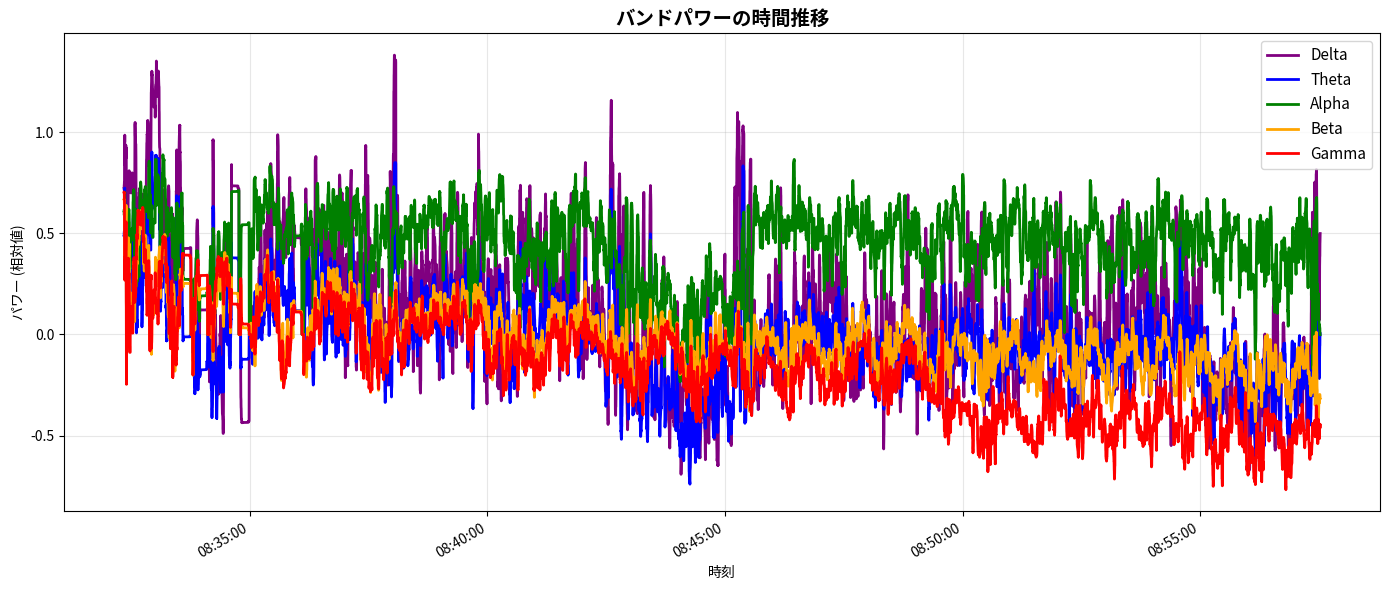

Alpha波が高いとリラックス状態、Beta波が高いと集中状態を示します


In [4]:
# 移動平均を計算
rolling_window = 50
rolling = df.copy()

for band in bands:
    cols = [c for c in df.columns if c.startswith(f'{band}_')]
    if not cols:
        continue
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    rolling[band] = numeric.mean(axis=1).rolling(
        window=rolling_window, min_periods=1
    ).mean()

# プロット
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['purple', 'blue', 'green', 'orange', 'red']

for band, color in zip(bands, colors):
    if band in rolling.columns:
        ax.plot(df['TimeStamp'], rolling[band], label=band, color=color, linewidth=2)

ax.set_title('バンドパワーの時間推移', fontsize=14, fontweight='bold')
ax.set_xlabel('時刻')
ax.set_ylabel('パワー (相対値)')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print('Alpha波が高いとリラックス状態、Beta波が高いと集中状態を示します')

## 5. 周波数解析（FFT・スペクトログラム）

脳波の「音楽的なスペクトル」を見てみましょう。

### 5.1 パワースペクトル密度（PSD）

どの周波数帯にエネルギーが集中しているかを確認します。

In [5]:
# RAWチャネルの検出
raw_cols = [c for c in df.columns if c.startswith('RAW_')]

# MNE用にRAWデータを準備
if raw_cols:
    # 数値変換と前処理
    numeric = df[raw_cols].apply(pd.to_numeric, errors='coerce')
    frame = pd.concat([df['TimeStamp'], numeric], axis=1)
    frame = frame.set_index('TimeStamp')
    
    # 重複タイムスタンプは平均化
    frame = frame.groupby(level=0).mean()
    
    # 時間補間で欠損値を埋める
    frame = frame.interpolate(method='time').ffill().bfill()
    
    # サンプリングレートの推定
    diffs = frame.index.to_series().diff().dropna()
    dt_seconds = diffs.median().total_seconds()
    sfreq = 1.0 / dt_seconds if dt_seconds > 0 else 256.0
    
    # MNE RawArrayの作成
    ch_names = list(frame.columns)
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # μVスケールをVに変換
    data = frame.to_numpy().T * 1e-6
    
    raw = mne.io.RawArray(data, info, copy='auto', verbose=False)
    
    # DCドリフト軽減のためのハイパスフィルタ
    if sfreq > 2.0:
        raw = raw.filter(l_freq=1.0, h_freq=None, fir_design='firwin', verbose=False)
    
    print(f'検出されたチャネル: {ch_names}')
    print(f'推定サンプリングレート: {sfreq:.2f} Hz')
    print(f'サンプル数: {len(frame)}')
else:
    print('RAWチャネルが見つかりません')

検出されたチャネル: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
推定サンプリングレート: 333.33 Hz
サンプル数: 73743


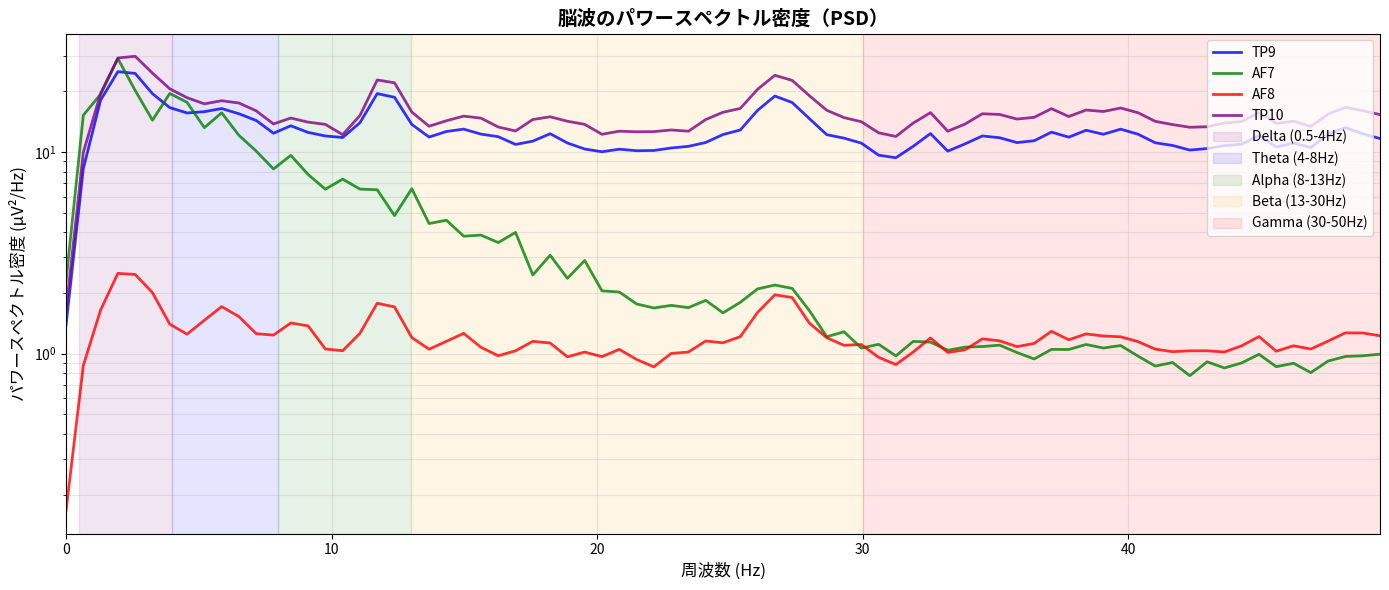

周波数範囲: 0 - 49.48 Hz

各バンドのピーク位置:
  Delta: 1.95 Hz
  Theta: 4.56 Hz
  Alpha: 11.72 Hz
  Beta: 26.69 Hz
  Gamma: 48.18 Hz


In [6]:
# PSD計算とプロット
if raw_cols:
    max_freq = 50.0
    nyquist = sfreq / 2.0
    fmax = min(max_freq, max(nyquist - 1e-6, nyquist * 0.9))
    
    n_fft = min(512, len(raw.times))
    spectrum = raw.compute_psd(
        method='welch',
        n_fft=n_fft,
        n_overlap=n_fft // 2,
        fmax=fmax,
        verbose=False,
    )
    
    freqs = spectrum.freqs
    psds = spectrum.get_data()
    psds = np.maximum(psds, np.finfo(float).eps)
    
    # V^2/Hz を μV^2/Hz へ変換
    psds_uv = psds * 1e12
    
    # プロット
    fig, ax = plt.subplots(figsize=(14, 6))
    channel_colors = ['blue', 'green', 'red', 'purple']
    
    for ch_name, psd, color in zip(raw.ch_names, psds_uv, channel_colors):
        channel_label = ch_name.replace('RAW_', '')
        ax.plot(freqs, psd, label=channel_label, linewidth=2, color=color, alpha=0.8)
    
    # バンド領域をハイライト
    band_ranges = {
        'Delta': (0.5, 4, 'purple'),
        'Theta': (4, 8, 'blue'),
        'Alpha': (8, 13, 'green'),
        'Beta': (13, 30, 'orange'),
        'Gamma': (30, 50, 'red')
    }
    
    for band, (low, high, color) in band_ranges.items():
        ax.axvspan(low, high, alpha=0.1, color=color, label=f'{band} ({low}-{high}Hz)')
    
    ax.set_xlim(0, min(max_freq, freqs.max()))
    ax.set_yscale('log')
    ax.set_xlabel('周波数 (Hz)', fontsize=12)
    ax.set_ylabel('パワースペクトル密度 (μV²/Hz)', fontsize=12)
    ax.set_title('脳波のパワースペクトル密度（PSD）', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print(f'周波数範囲: 0 - {freqs.max():.2f} Hz')
    print('\n各バンドのピーク位置:')
    for band, (low, high, _) in band_ranges.items():
        mask = (freqs >= low) & (freqs <= high)
        if mask.any():
            band_freqs = freqs[mask]
            band_psds = psds_uv.mean(axis=0)[mask]
            peak_idx = band_psds.argmax()
            print(f'  {band}: {band_freqs[peak_idx]:.2f} Hz')

### 5.2 スペクトログラム

時間とともに周波数分布がどう変化するかを見てみましょう。

スペクトログラムを計算中... (チャネル: RAW_TP9)


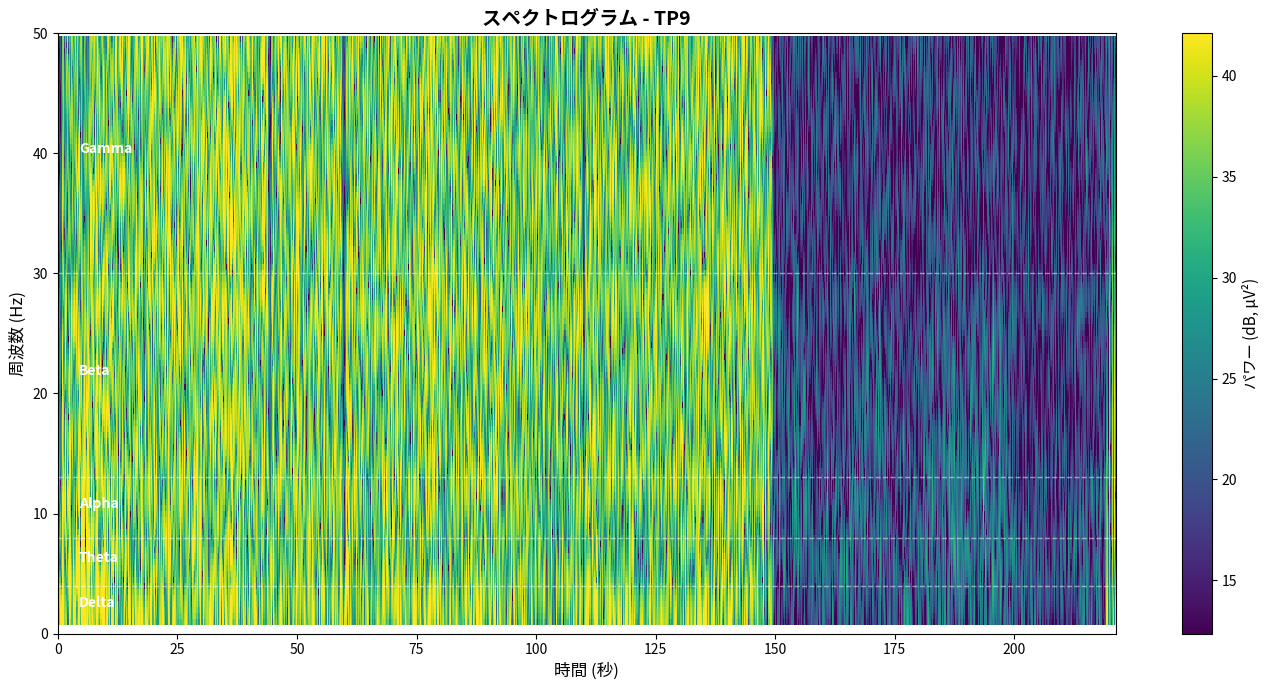

周波数範囲: 1.00 - 49.50 Hz
時間範囲: 0.00 - 221.23 秒


In [7]:
# スペクトログラム分析
if raw_cols and 'RAW_TP9' in raw.ch_names:
    channel = 'RAW_TP9'
    max_freq = 50.0
    
    nyquist = sfreq / 2.0
    fmax = min(max_freq, max(nyquist - 1e-6, nyquist * 0.9))
    
    # 指定チャネルのデータを取得
    ch_idx = raw.ch_names.index(channel)
    
    # TFRスペクトログラムを計算
    freqs_tfr = np.arange(1.0, fmax, 0.5)
    n_cycles = freqs_tfr / 2.0
    
    print(f'スペクトログラムを計算中... (チャネル: {channel})')
    
    # Morlet waveletを使用してtime-frequency解析
    data_3d = raw.get_data()[ch_idx:ch_idx+1, :][np.newaxis, :, :]
    power = mne.time_frequency.tfr_array_morlet(
        data_3d,
        sfreq=sfreq,
        freqs=freqs_tfr,
        n_cycles=n_cycles,
        output='power',
        verbose=False,
    )
    
    # V^2 を μV^2 へ変換
    power_uv = power[0, 0] * 1e12
    
    # dB変換
    power_db = 10 * np.log10(power_uv)
    
    # プロット
    fig, ax = plt.subplots(figsize=(14, 7))
    times = raw.times
    
    im = ax.pcolormesh(
        times,
        freqs_tfr,
        power_db,
        shading='auto',
        cmap='viridis',
        vmin=np.percentile(power_db, 5),
        vmax=np.percentile(power_db, 95)
    )
    
    # バンド境界線
    for band, (low, high, _) in band_ranges.items():
        if low <= fmax:
            ax.axhline(y=low, color='white', linestyle='--', alpha=0.5, linewidth=1)
            if high <= fmax:
                ax.text(times[-1] * 0.02, (low + high) / 2, band, 
                       color='white', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('時間 (秒)', fontsize=12)
    ax.set_ylabel('周波数 (Hz)', fontsize=12)
    ax.set_title(f'スペクトログラム - {channel.replace("RAW_", "")}', 
                fontsize=14, fontweight='bold')
    ax.set_ylim(0, fmax)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('パワー (dB, μV²)', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f'周波数範囲: {freqs_tfr.min():.2f} - {freqs_tfr.max():.2f} Hz')
    print(f'時間範囲: {times[0]:.2f} - {times[-1]:.2f} 秒')
elif raw_cols:
    print('RAW_TP9チャネルが見つかりません')

## 6. 条件比較とスコア化

脳波データから「リラックス度」や「集中度」といった指標を計算してみましょう。

### 6.1 バンド比率の計算

- **リラックス度**: Alpha/Beta 比率（高いほどリラックス）
- **集中度**: Beta/Theta 比率（高いほど集中）
- **瞑想深度**: Theta/Alpha 比率（高いほど深い瞑想状態）

/tmp/ipykernel_25686/479531568.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ratio_df_resampled = ratio_df.set_index('TimeStamp').resample(resample_interval).mean().reset_index()


元のデータ数: 377893 行
リサンプリング後: 152 行（10Sごと）
計測時間: 1511 秒



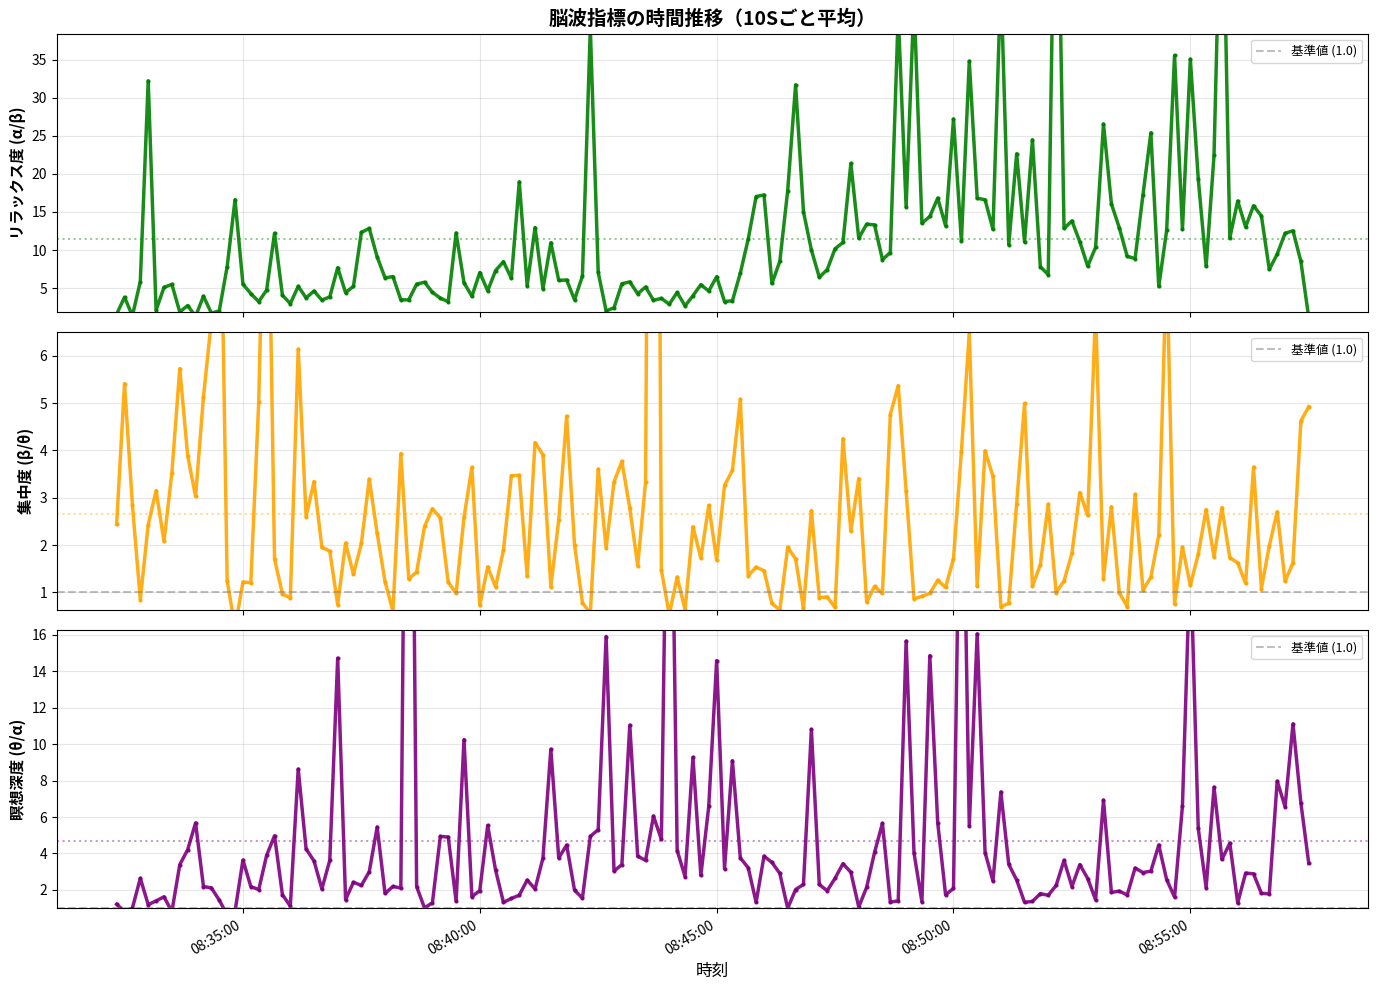

=== バンド比率データの品質確認 ===

リラックス度 (α/β):
  有効データ数: 152 / 152
  範囲: 1.105 ~ 73.764
  平均: 11.436, 中央値: 7.838
  標準偏差: 11.091

集中度 (β/θ):
  有効データ数: 152 / 152
  範囲: 0.255 ~ 31.495
  平均: 2.666, 中央値: 1.953
  標準偏差: 3.004

瞑想深度 (θ/α):
  有効データ数: 152 / 152
  範囲: 0.633 ~ 50.909
  平均: 4.680, 中央値: 2.961
  標準偏差: 6.106


In [8]:
# バンド比率の計算
ratio_df = pd.DataFrame({'TimeStamp': df['TimeStamp']})

ratio_configs = [
    ('リラックス度 (α/β)', 'Alpha', 'Beta'),
    ('集中度 (β/θ)', 'Beta', 'Theta'),
    ('瞑想深度 (θ/α)', 'Theta', 'Alpha'),
]

for ratio_name, num_band, den_band in ratio_configs:
    ratios = []
    for col in [c for c in df.columns if c.startswith(f'{num_band}_')]:
        electrode = col.split('_', 1)[1]
        den_col = f'{den_band}_{electrode}'
        if den_col in df.columns:
            num_vals = pd.to_numeric(df[col], errors='coerce')
            den_vals = pd.to_numeric(df[den_col], errors='coerce')
            
            # 負の値を絶対値に変換（パワーは本来正の値のはず）
            num_vals = num_vals.abs()
            den_vals = den_vals.abs()
            
            # ゼロ除算を避ける
            den_vals = den_vals.replace(0, np.nan)
            
            ratio = (num_vals / den_vals).replace([np.inf, -np.inf], np.nan)
            ratios.append(ratio)
    
    if ratios:
        # 各チャネルの比率の平均を取る
        ratio_df[ratio_name] = pd.concat(ratios, axis=1).mean(axis=1)

# リサンプリング頻度の検討
# 脳波の状態変化は数秒〜数十秒で起こるため、5-10秒程度が適切
# オプション:
# - '5S': 5秒（より詳細な変化を捉える）
# - '10S': 10秒（変化とスムーズさのバランス）推奨
# - '30S': 30秒（大きな傾向を見る）
# - '1T': 1分（粗い傾向）

resample_interval = '10S'  # 10秒間隔（推奨）

ratio_df_resampled = ratio_df.set_index('TimeStamp').resample(resample_interval).mean().reset_index()

print(f'元のデータ数: {len(ratio_df)} 行')
print(f'リサンプリング後: {len(ratio_df_resampled)} 行（{resample_interval}ごと）')
print(f'計測時間: {(ratio_df["TimeStamp"].max() - ratio_df["TimeStamp"].min()).total_seconds():.0f} 秒\n')

# プロット
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
colors = ['green', 'orange', 'purple']

for i, (ratio_name, _, _) in enumerate(ratio_configs):
    if ratio_name in ratio_df_resampled.columns:
        # リサンプリング済みデータをプロット
        axes[i].plot(ratio_df_resampled['TimeStamp'], ratio_df_resampled[ratio_name], 
                    color=colors[i], linewidth=2.5, marker='o', markersize=2, alpha=0.9)
        axes[i].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5,
                       label='基準値 (1.0)')
        axes[i].set_ylabel(ratio_name, fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(loc='upper right', fontsize=9)
        
        # Y軸の範囲を適切に設定（外れ値の影響を抑える）
        data_values = ratio_df_resampled[ratio_name].dropna()
        if len(data_values) > 0:
            # 5%と95%パーセンタイルで範囲を設定
            y_min = max(0, data_values.quantile(0.05) * 0.9)
            y_max = data_values.quantile(0.95) * 1.1
            axes[i].set_ylim(y_min, y_max)
            
            # 統計情報を表示
            mean_val = data_values.mean()
            axes[i].axhline(y=mean_val, color=colors[i], linestyle=':', 
                          alpha=0.4, linewidth=1.5, label=f'平均 ({mean_val:.2f})')

axes[0].set_title(f'脳波指標の時間推移（{resample_interval}ごと平均）', 
                 fontsize=14, fontweight='bold')
axes[-1].set_xlabel('時刻', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# データ品質の確認
print('=== バンド比率データの品質確認 ===')
for ratio_name, _, _ in ratio_configs:
    if ratio_name in ratio_df_resampled.columns:
        values = ratio_df_resampled[ratio_name].dropna()
        print(f'\n{ratio_name}:')
        print(f'  有効データ数: {len(values)} / {len(ratio_df_resampled)}')
        print(f'  範囲: {values.min():.3f} ~ {values.max():.3f}')
        print(f'  平均: {values.mean():.3f}, 中央値: {values.median():.3f}')
        print(f'  標準偏差: {values.std():.3f}')

### 6.2 Peak Alpha Frequency (PAF) 分析

Peak Alpha Frequency（PAF）は、Alpha帯域（8-13 Hz）内で最大パワーを示す周波数です。

- **個人差の指標**: 認知機能や脳の状態を反映
- **年齢との関連**: 加齢により低下する傾向
- **認知機能**: 記憶力や処理速度と相関
- **瞑想評価**: 瞑想状態の深さを評価

=== Peak Alpha Frequency (PAF) ===

TP9: PAF = 11.72 Hz, Power = 19.50 μV²/Hz
AF7: PAF = 8.46 Hz, Power = 9.63 μV²/Hz
AF8: PAF = 11.72 Hz, Power = 1.78 μV²/Hz
TP10: PAF = 11.72 Hz, Power = 22.78 μV²/Hz

Individual Alpha Frequency (IAF): 10.90 ± 1.41 Hz


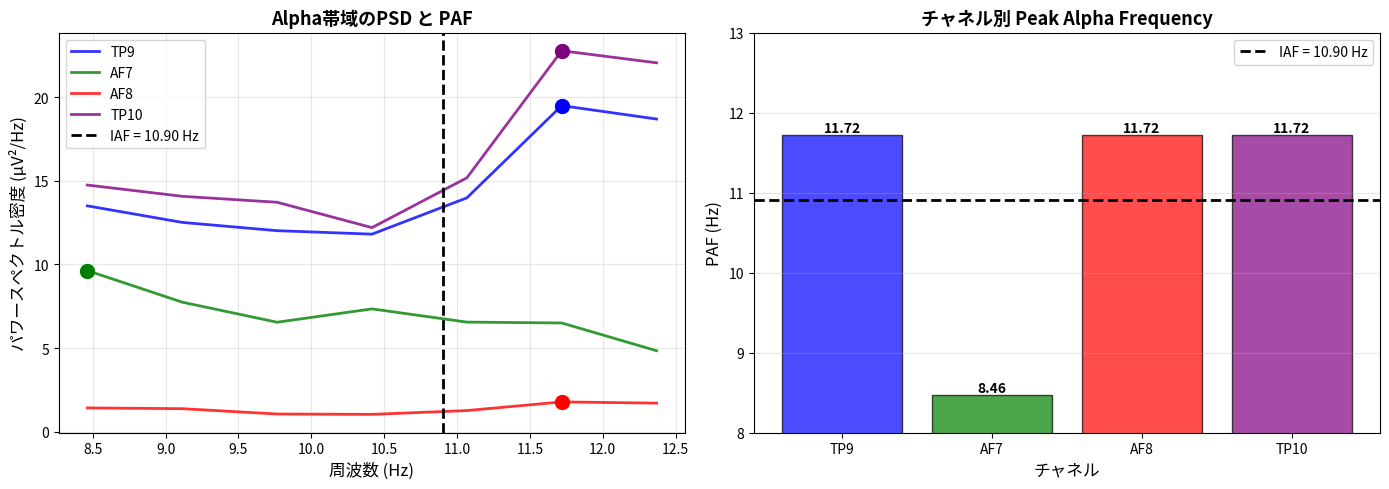

In [9]:
# Peak Alpha Frequency (PAF) の計算
if raw_cols and 'spectrum' in locals():
    alpha_low, alpha_high = 8.0, 13.0
    
    # Alpha帯域のマスク
    alpha_mask = (freqs >= alpha_low) & (freqs <= alpha_high)
    alpha_freqs = freqs[alpha_mask]
    
    # 各チャネルのPAFを計算
    paf_results = {}
    
    print('=== Peak Alpha Frequency (PAF) ===\n')
    
    for i, ch_name in enumerate(raw.ch_names):
        ch_label = ch_name.replace('RAW_', '')
        alpha_psd = psds_uv[i][alpha_mask]
        
        # ピーク周波数を検出
        peak_idx = alpha_psd.argmax()
        paf = alpha_freqs[peak_idx]
        peak_power = alpha_psd[peak_idx]
        
        paf_results[ch_label] = {
            'PAF': paf,
            'Power': peak_power,
            'PSD': alpha_psd,
        }
        
        print(f'{ch_label}: PAF = {paf:.2f} Hz, Power = {peak_power:.2f} μV²/Hz')
    
    # Individual Alpha Frequency (IAF) - 全チャネル平均
    all_pafs = [v['PAF'] for v in paf_results.values()]
    iaf = np.mean(all_pafs)
    iaf_std = np.std(all_pafs)
    
    print(f'\nIndividual Alpha Frequency (IAF): {iaf:.2f} ± {iaf_std:.2f} Hz')
    
    # PAFの可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左図: Alpha帯域のPSDとPAF
    for ch_label, result in paf_results.items():
        color = channel_colors[list(paf_results.keys()).index(ch_label)]
        ax1.plot(alpha_freqs, result['PSD'], label=ch_label, 
                linewidth=2, color=color, alpha=0.8)
        # PAF位置をマーカーで表示
        ax1.scatter(result['PAF'], result['Power'], 
                   s=100, color=color, marker='o', zorder=5)
    
    ax1.axvline(x=iaf, color='black', linestyle='--', linewidth=2, 
               label=f'IAF = {iaf:.2f} Hz')
    ax1.set_xlabel('周波数 (Hz)', fontsize=12)
    ax1.set_ylabel('パワースペクトル密度 (μV²/Hz)', fontsize=12)
    ax1.set_title('Alpha帯域のPSD と PAF', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 右図: チャネル別PAFの棒グラフ
    channels = list(paf_results.keys())
    pafs = [paf_results[ch]['PAF'] for ch in channels]
    colors_bar = [channel_colors[i] for i in range(len(channels))]
    
    bars = ax2.bar(channels, pafs, color=colors_bar, alpha=0.7, edgecolor='black')
    ax2.axhline(y=iaf, color='black', linestyle='--', linewidth=2, 
               label=f'IAF = {iaf:.2f} Hz')
    ax2.set_ylabel('PAF (Hz)', fontsize=12)
    ax2.set_xlabel('チャネル', fontsize=12)
    ax2.set_title('チャネル別 Peak Alpha Frequency', fontsize=13, fontweight='bold')
    ax2.set_ylim(alpha_low, alpha_high)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 値を棒グラフ上に表示
    for bar, paf in zip(bars, pafs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{paf:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print('PSDデータが利用できません。先にPSD分析を実行してください。')

#### PAFの時間的変化

スペクトログラムデータから、PAFが時間とともにどう変化するかを追跡します。

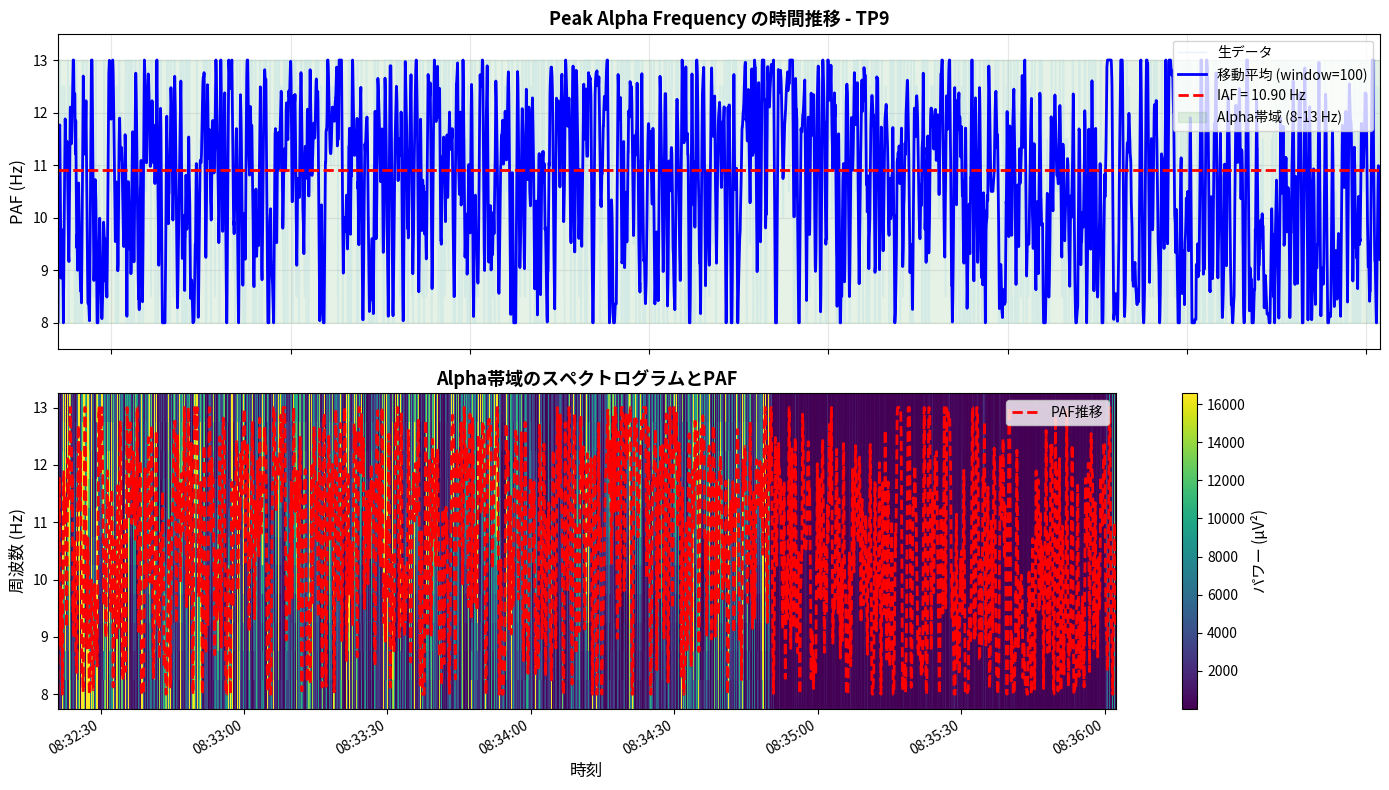


PAF統計（TP9チャネル）:
  平均PAF: 10.65 Hz
  中央値: 11.00 Hz
  標準偏差: 1.98 Hz
  最小値: 8.00 Hz
  最大値: 13.00 Hz
  変動係数: 18.60%

PAF安定性評価: 変動大


In [10]:
# PAFの時間的変化を追跡
if raw_cols and 'power_uv' in locals():
    # Alpha帯域のマスク（スペクトログラム用）
    alpha_mask_tfr = (freqs_tfr >= alpha_low) & (freqs_tfr <= alpha_high)
    alpha_freqs_tfr = freqs_tfr[alpha_mask_tfr]
    alpha_power_tfr = power_uv[alpha_mask_tfr, :]
    
    # 各時間点でのPAFを計算
    paf_over_time = []
    for t_idx in range(alpha_power_tfr.shape[1]):
        power_at_t = alpha_power_tfr[:, t_idx]
        peak_idx = power_at_t.argmax()
        paf_at_t = alpha_freqs_tfr[peak_idx]
        paf_over_time.append(paf_at_t)
    
    paf_over_time = np.array(paf_over_time)
    
    # 移動平均でスムージング
    window_size = 100
    paf_smoothed = pd.Series(paf_over_time).rolling(
        window=window_size, min_periods=1, center=True
    ).mean().values
    
    # 時間軸をタイムスタンプに変換
    start_time = df['TimeStamp'].min()
    time_stamps = [start_time + pd.Timedelta(seconds=t) for t in times]
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # 上図: PAFの時間変化
    ax1.plot(time_stamps, paf_over_time, color='lightblue', 
            alpha=0.3, linewidth=1, label='生データ')
    ax1.plot(time_stamps, paf_smoothed, color='blue', 
            linewidth=2, label=f'移動平均 (window={window_size})')
    ax1.axhline(y=iaf, color='red', linestyle='--', linewidth=2, 
               label=f'IAF = {iaf:.2f} Hz')
    ax1.fill_between(time_stamps, alpha_low, alpha_high, 
                     alpha=0.1, color='green', label='Alpha帯域 (8-13 Hz)')
    ax1.set_ylabel('PAF (Hz)', fontsize=12)
    ax1.set_title(f'Peak Alpha Frequency の時間推移 - {channel.replace("RAW_", "")}', 
                 fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(alpha_low - 0.5, alpha_high + 0.5)
    
    # 下図: PAFの変動性（スペクトログラム）
    im = ax2.pcolormesh(
        time_stamps,
        alpha_freqs_tfr,
        alpha_power_tfr,
        shading='auto',
        cmap='viridis',
        vmin=np.percentile(alpha_power_tfr, 5),
        vmax=np.percentile(alpha_power_tfr, 95)
    )
    ax2.plot(time_stamps, paf_smoothed, color='red', 
            linewidth=2, linestyle='--', label='PAF推移')
    ax2.set_xlabel('時刻', fontsize=12)
    ax2.set_ylabel('周波数 (Hz)', fontsize=12)
    ax2.set_title('Alpha帯域のスペクトログラムとPAF', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    
    cbar = fig.colorbar(im, ax=ax2)
    cbar.set_label('パワー (μV²)', fontsize=11)
    
    # X軸フォーマット
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print(f'\nPAF統計（{channel.replace("RAW_", "")}チャネル）:')
    print(f'  平均PAF: {np.mean(paf_over_time):.2f} Hz')
    print(f'  中央値: {np.median(paf_over_time):.2f} Hz')
    print(f'  標準偏差: {np.std(paf_over_time):.2f} Hz')
    print(f'  最小値: {np.min(paf_over_time):.2f} Hz')
    print(f'  最大値: {np.max(paf_over_time):.2f} Hz')
    print(f'  変動係数: {(np.std(paf_over_time) / np.mean(paf_over_time) * 100):.2f}%')
    
    # PAFの安定性評価
    cv = np.std(paf_over_time) / np.mean(paf_over_time) * 100
    if cv < 2:
        stability = '非常に安定'
    elif cv < 5:
        stability = '安定'
    elif cv < 10:
        stability = 'やや変動あり'
    else:
        stability = '変動大'
    
    print(f'\nPAF安定性評価: {stability}')
else:
    print('スペクトログラムデータが利用できません。先にスペクトログラム分析を実行してください。')

### 6.3 スコアサマリー

全体の平均スコアを計算して、セッション全体の傾向を把握します。

In [11]:
# スパイク（外れ値）の検出と分析
from scipy import stats

print('=== スパイク（外れ値）分析 ===\n')

for ratio_name, _, _ in ratio_configs:
    if ratio_name in ratio_df_resampled.columns:
        values = ratio_df_resampled[ratio_name].dropna()
        
        # Z-scoreで外れ値を検出（|Z| > 3 を外れ値とする）
        z_scores = np.abs(stats.zscore(values))
        outliers = values[z_scores > 3]
        
        # 変動係数（CV）を計算
        cv = (values.std() / values.mean()) * 100
        
        print(f'{ratio_name}:')
        print(f'  外れ値の数: {len(outliers)} / {len(values)} ({len(outliers)/len(values)*100:.1f}%)')
        if len(outliers) > 0:
            print(f'  外れ値の範囲: {outliers.min():.3f} ~ {outliers.max():.3f}')
        print(f'  変動係数（CV）: {cv:.1f}% ', end='')
        
        # CVによるデータ品質評価
        if cv < 20:
            print('→ 安定')
        elif cv < 40:
            print('→ やや変動あり')
        else:
            print('→ 変動大（ノイズ多い可能性）')
        
        # 急激な変化を検出
        diff = values.diff().abs()
        large_changes = diff[diff > diff.quantile(0.95)]
        print(f'  急激な変化（上位5%）: {len(large_changes)} 箇所')
        print()

# アーティファクト対策の推奨事項
print('=== アーティファクト（ノイズ）対策の推奨 ===')
print('1. 外れ値が多い場合：')
print('   - メディアンフィルタや異常値除去を適用')
print('   - より長いリサンプリング間隔（30秒など）を試す')
print('2. 変動係数が高い場合：')
print('   - 測定時の身体の動きを最小限に')
print('   - 電極の接触状態を確認')
print('3. 真の脳波変化を保ちたい場合：')
print('   - ロバストな統計手法（メディアン、パーセンタイル）を使用')
print('   - 外れ値を除外してから再プロット')

=== スパイク（外れ値）分析 ===

リラックス度 (α/β):
  外れ値の数: 3 / 152 (2.0%)
  外れ値の範囲: 45.576 ~ 73.764
  変動係数（CV）: 97.0% → 変動大（ノイズ多い可能性）
  急激な変化（上位5%）: 8 箇所

集中度 (β/θ):
  外れ値の数: 2 / 152 (1.3%)
  外れ値の範囲: 12.188 ~ 31.495
  変動係数（CV）: 112.7% → 変動大（ノイズ多い可能性）
  急激な変化（上位5%）: 8 箇所

瞑想深度 (θ/α):
  外れ値の数: 3 / 152 (2.0%)
  外れ値の範囲: 31.086 ~ 50.909
  変動係数（CV）: 130.5% → 変動大（ノイズ多い可能性）
  急激な変化（上位5%）: 8 箇所

=== アーティファクト（ノイズ）対策の推奨 ===
1. 外れ値が多い場合：
   - メディアンフィルタや異常値除去を適用
   - より長いリサンプリング間隔（30秒など）を試す
2. 変動係数が高い場合：
   - 測定時の身体の動きを最小限に
   - 電極の接触状態を確認
3. 真の脳波変化を保ちたい場合：
   - ロバストな統計手法（メディアン、パーセンタイル）を使用
   - 外れ値を除外してから再プロット


In [12]:
# スコアサマリーの計算
summary_scores = []

for ratio_name, _, _ in ratio_configs:
    col = ratio_name
    if col in ratio_df.columns:
        values = ratio_df[col].dropna()
        summary_scores.append({
            '指標': ratio_name,
            '平均値': values.mean(),
            '中央値': values.median(),
            '標準偏差': values.std(),
            '最小値': values.min(),
            '最大値': values.max(),
        })

score_summary_df = pd.DataFrame(summary_scores)
display(score_summary_df.style.format({
    '平均値': '{:.3f}',
    '中央値': '{:.3f}',
    '標準偏差': '{:.3f}',
    '最小値': '{:.3f}',
    '最大値': '{:.3f}'
}))

# 簡易評価
print('\n=== セッション評価 ===')
for ratio_name, _, _ in ratio_configs:
    col = ratio_name
    if col in ratio_df.columns:
        avg_value = ratio_df[col].mean()
        
        if 'リラックス' in ratio_name:
            level = 'とても高い' if avg_value > 2.0 else '高い' if avg_value > 1.0 else '普通'
        elif '集中' in ratio_name:
            level = 'とても高い' if avg_value > 2.0 else '高い' if avg_value > 1.0 else '普通'
        elif '瞑想' in ratio_name:
            level = '深い' if avg_value > 1.5 else '中程度' if avg_value > 0.8 else '浅い'
        else:
            level = '不明'
        
        print(f'{ratio_name}: {avg_value:.3f} ({level})')

,指標,平均値,中央値,標準偏差,最小値,最大値
0,リラックス度 (α/β),11.696,4.075,86.688,0.140,6504.550
1,集中度 (β/θ),2.647,0.828,14.809,0.176,715.875
2,瞑想深度 (θ/α),4.784,1.460,51.831,0.132,4122.835



=== セッション評価 ===
リラックス度 (α/β): 11.696 (とても高い)
集中度 (β/θ): 2.647 (とても高い)
瞑想深度 (θ/α): 4.784 (深い)


## 7. まとめ

このノートブックでは、Muse脳波データの基本的な分析を行いました：

1. **データ読み込み**: CSVデータの読み込みと前処理
2. **基本統計**: 各周波数バンドの特性を把握
3. **バンドパワー**: 時間経過に伴う各バンドの変化を追跡
4. **周波数解析**: PSDとスペクトログラムで周波数特性を詳細分析
5. **指標分析**: リラックス度、集中度、瞑想深度の数値化
6. **PAF分析**: Peak Alpha Frequencyの測定と時間変化の追跡

## 次のステップ

詳細な分析については、以下の専門ノートブックを参照してください：

### 左右半球差分析

[laterality_analysis.ipynb](laterality_analysis.ipynb)では、以下を分析します：

- 左右半球の非対称性指数（AI）
- 前頭部Alpha非対称性と感情状態
- 前頭部Beta非対称性と認知処理の偏り
- 時系列変化とヒートマップ可視化

### サマタ瞑想のfmシータ波分析

[fm_theta_analysis.ipynb](fm_theta_analysis.ipynb)では、以下を分析します：

- 前頭部シータ波パワーの時間推移
- シータ/アルファ比による瞑想深度測定
- 周波数詳細分析によるfmシータの検出
- 瞑想の深まりの評価